# Book Recommendation

This is a quick weekend project building a collaborative filtering algorithm on the Book Crossing dataset found <a href="http://www2.informatik.uni-freiburg.de/~cziegler/BX/">here</a>.

In [79]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
users=pd.read_csv('BX-Users.csv', sep=';', escapechar='\\',encoding='CP1252', low_memory=False)
books=pd.read_csv('BX-Books.csv', sep=';', escapechar='\\',encoding='CP1252', low_memory=False)
ratings=pd.read_csv('BX-Book-Ratings.csv', sep=';', escapechar='\\',encoding='CP1252', low_memory=False)
print(users.shape, books.shape, ratings.shape)
users.head()

(278858, 3) (271379, 8) (1149780, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [80]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [81]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# 1. Quick EDA 

Nothing fancy, just understanding the basic structure of the data.

**Users**

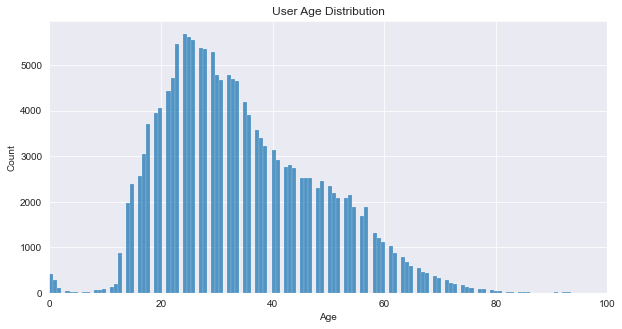

In [82]:
#age distribution 
fig=plt.figure(figsize=(10,5))
sns.histplot(data=users, x='Age')
plt.xlim(left=0, right=100);
plt.title('User Age Distribution');

In [83]:
import re
users['Country']=users['Location'].apply(lambda x: re.sub('.*?\,\s','',x))
country_counts=users['Country'].value_counts()
country_counts.head(10)

usa               139712
canada             21658
united kingdom     18556
germany            17073
spain              13258
australia          11785
italy              11270
france              3487
portugal            3390
new zealand         3120
Name: Country, dtype: int64

**Books**

In [84]:
author_counts=books['Book-Author'].value_counts()
publisher_counts=books['Publisher'].value_counts()
print('Author Counts: \n', author_counts.head(10),'\n\n')
print('Publisher Counts: \n', publisher_counts.head(10))

Author Counts: 
 Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Francine Pascal        373
Carolyn Keene          373
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: Book-Author, dtype: int64 


Publisher Counts: 
 Harlequin                   7536
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3647
Scholastic                  3160
Simon &amp; Schuster        2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: Publisher, dtype: int64


Number of books pre-1900:  4623


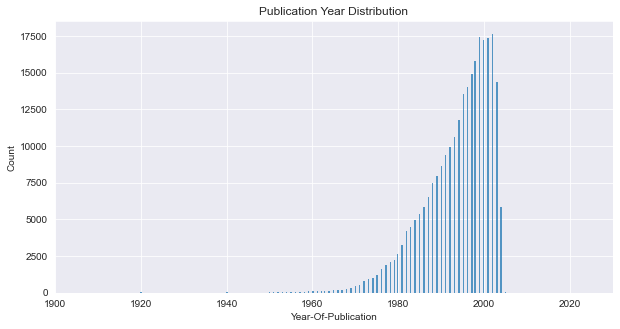

In [85]:
fig=plt.figure(figsize=(10,5))
sns.histplot(data=books, x='Year-Of-Publication')
plt.xlim(left=1900, right=2030)
plt.title('Publication Year Distribution');
print('Number of books pre-1900: ', books[books['Year-Of-Publication']<1900].shape[0])

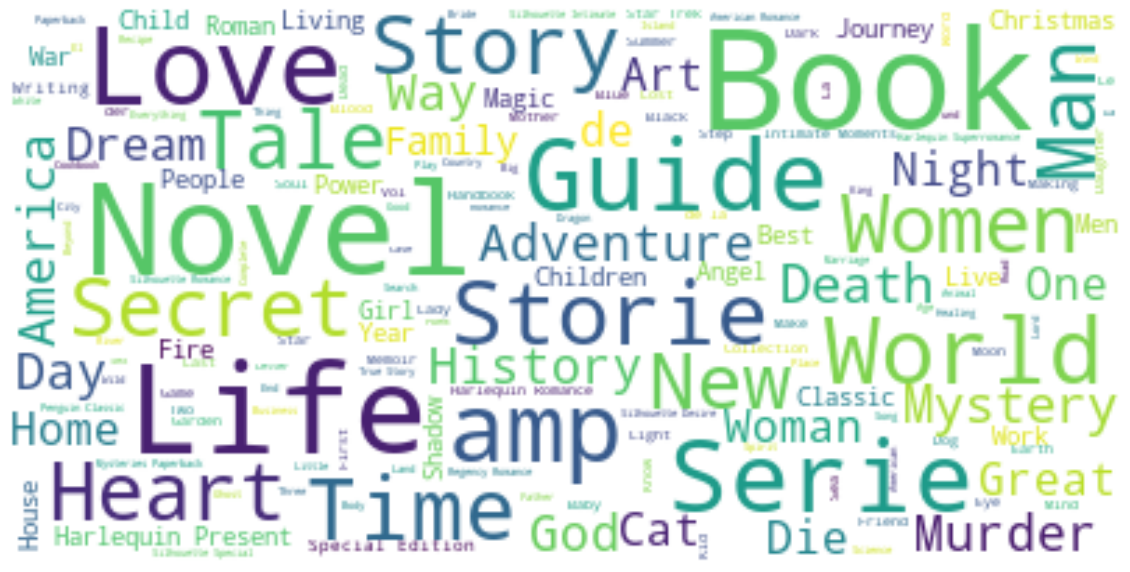

In [86]:
#fix this
from wordcloud import WordCloud
titles=[]
for idx, book in books.iterrows():
    titles.append(book['Book-Title'])
titles_str=" ".join(titles)
for word in ['&amp;','amp','the','a','an']:
    titles_str.replace(word, ' ') 
wc=WordCloud(background_color='white', max_font_size=50, max_words=1000, random_state=42).generate(titles_str)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

**Ratings**

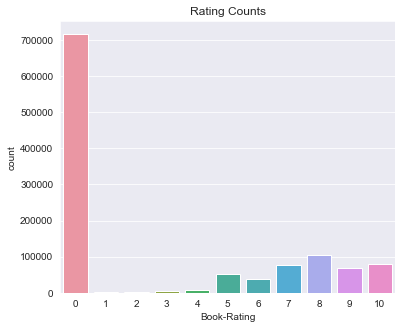

In [87]:
plt.figure(figsize=(6,5))
sns.countplot(data=ratings, x='Book-Rating')
plt.title('Rating Counts');

**Note:** The 1-10 are explicit ratings whereas the 0 is an implicit rating. More detail <a href="https://www.ercim.eu/publication/ws-proceedings/DELOS5/nichols.pdf">here</a>. A simple example of an implicit rating could be that the user bought the book. 

In [88]:
user_counts=ratings['User-ID'].value_counts()
user_counts.head(10)

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: User-ID, dtype: int64

In [89]:
#ratings of highest reviewed books
rating_counts=pd.pivot_table(ratings,index='ISBN', aggfunc={'Book-Rating':'mean', 'ISBN':'count'})
rating_counts.rename(columns={'Book-Rating':'Mean_Rating', 'ISBN':'Count'}, inplace=True)
rating_counts=rating_counts.merge(books[['ISBN','Book-Title']], on=['ISBN'], how='left')
rating_counts.sort_values(by='Count', ascending=False, inplace=True)
rating_counts.head(10)

,ISBN,Mean_Rating,Count,Book-Title
247419,0971880107,1.019584,2502,Wild Animus
47382,0316666343,4.468726,1295,The Lovely Bones: A Novel
83370,0385504209,4.652322,883,The Da Vinci Code
9648,0060928336,3.448087,732,Divine Secrets of the Ya-Ya Sisterhood: A Novel
41018,0312195516,4.334716,723,The Red Tent (Bestselling Backlist)
101681,044023722X,3.187017,647,A Painted House
166716,0679781587,4.381847,639,NaN
28164,0142001740,4.219512,615,The Secret Life of Bees
166445,067976402X,3.255700,614,Snow Falling on Cedars
153631,0671027360,3.718430,586,Angels &amp; Demons


In [90]:
#user id counts, average rating pivot table
user_ratings=pd.pivot_table(ratings, index='User-ID', aggfunc={'User-ID':'count', 'Book-Rating':'mean'})
user_ratings.rename(columns={'User-ID':'Review_Count','Book-Rating':'Mean_Rating'}, inplace=True)
user_ratings.sort_values(by='Review_Count', ascending=False, inplace=True)
user_ratings.head(10)

,Mean_Rating,Review_Count
User-ID,,
11676,4.564917,13602
198711,0.016291,7550
153662,2.786872,6109
98391,8.728230,5891
35859,1.075897,5850
212898,0.003135,4785
278418,0.159276,4533
76352,0.145233,3367
110973,0.787742,3100


# 2. Recommendation Model

Using Funk SVD (from the 2006 Netflix competition) tested on both whole dataset and users/books with decent number of reviews.

https://github.com/gbolmier/funk-svd  

http://sifter.org/simon/journal/20061211.html

In [95]:
#Trimmed dset of users in the set of users with >20 ratings and books in set of books with >10 ratings
users_index = user_ratings[user_ratings['Review_Count']>20].index
books_index = rating_counts[rating_counts['Count']>10].ISBN.values
def users_index_fn(user_id):
    if user_id in users_index:
        return 1
    else: 
        return 0
def books_index_fn(book_id):
    if book_id in books_index:
        return 1
    else:
        return 0
    
recommender_df=ratings[(ratings['User-ID'].apply(users_index_fn)==1) & (ratings['ISBN'].apply(books_index_fn)==1)]
recommender_df.reset_index(inplace=True, drop=True)

In [99]:
#model class
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

ratings.rename(columns={'User-ID':'u_id','ISBN':'i_id','Book-Rating':'rating'}, inplace=True)
recommender_df.rename(columns={'User-ID':'u_id','ISBN':'i_id','Book-Rating':'rating'}, inplace=True)

class recommender:
    """
    Simple recommender class using SVD with an MAE evaluation metric. 
    """
    def __init__(self, learning_rate=0.001, regularization=0.01, n_epochs=50, n_factors=50, min_rating=1, max_rating=10):
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.n_epochs=n_epochs
        self.n_factors=n_factors
        self.min_rating=min_rating
        self.max_rating=max_rating
        self.model=SVD(learning_rate=learning_rate, regularization=regularization, n_epochs=n_epochs, n_factors=n_factors,\
                       min_rating=min_rating, max_rating=max_rating)
    
        self.fitted=False
        
    def fit(self, train, early_stopping=True, shuffle=False):
        X=train.sample(frac=0.8, random_state=42)
        X_val=train.drop(X.index.to_list())
        self.model.fit(X=X, X_val=X_val, early_stopping=early_stopping, shuffle=shuffle)
        self.fitted=True
        
    def predict(self, test):
        if self.fitted==False:
            raise Exception('Fit before you make a prediction.')
        else:
            preds=self.model.predict(test)
            return preds
    
    def accuracy(self, test, preds):
        #applies mae to books user has already rated (metrics such as map@k might be more appropriate for this task)
        mae=mean_absolute_error(test['rating'], preds)
        return mae
    
    def cv(self, data, n_splits=5, random_state=42):
        kf=KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        losses=[]
        i=0
        for train_idx, test_idx in kf.split(data):
            i+=1
            train, test = data.iloc[list(train_idx)], data.iloc[list(test_idx)]
            self.fit(train)
            preds=self.predict(test)
            fold_loss=self.accuracy(test, preds)
            print('Loss fold '+str(i)+': ', fold_loss)
            losses.append(fold_loss)
        cv_loss=np.mean(losses)
        print('CV Loss:', cv_loss)
        return cv_loss
        
    
    def predict_user_books(self, train, user, n_books=5):
        """
        user is user_id, train is the full training set for which the model was fit. n_books is number of books to display
        returns list of books
        """
        user_ratings=train[train['u_id']==user]
        user_df=pd.DataFrame(train.i_id.unique(), columns=['i_id'])
        user_df['u_id']=user
        user_df=user_df.merge(user_ratings, on=['u_id', 'i_id'], how='left')
        preds=self.predict(user_df)
        user_df['pred_rating']=preds
        user_df_unrated=user_df[user_df['rating'].isnull()]
        user_df_unrated.sort_values(by='pred_rating', ascending=False, inplace=True)
        top_books=list(user_df_unrated.i_id[:n_books])
        return top_books



In [100]:
model=recommender()
ratings_loss=model.cv(ratings)
recommender_loss=model.cv(recommender_df)
print('Full dataset loss:',ratings_loss,'\n Trimmed dataset loss:', recommender_loss)

Preprocessing data...

Epoch 1/50  | val_loss: 13.39 - val_rmse: 3.66 - val_mae: 3.27 - took 0.2 sec
Epoch 2/50  | val_loss: 13.00 - val_rmse: 3.61 - val_mae: 3.16 - took 0.2 sec
Epoch 3/50  | val_loss: 12.78 - val_rmse: 3.58 - val_mae: 3.10 - took 0.2 sec
Epoch 4/50  | val_loss: 12.63 - val_rmse: 3.55 - val_mae: 3.06 - took 0.2 sec
Epoch 5/50  | val_loss: 12.51 - val_rmse: 3.54 - val_mae: 3.03 - took 0.2 sec
Epoch 6/50  | val_loss: 12.42 - val_rmse: 3.52 - val_mae: 3.00 - took 0.2 sec
Epoch 7/50  | val_loss: 12.34 - val_rmse: 3.51 - val_mae: 2.98 - took 0.2 sec
Epoch 8/50  | val_loss: 12.28 - val_rmse: 3.50 - val_mae: 2.97 - took 0.2 sec
Epoch 9/50  | val_loss: 12.22 - val_rmse: 3.50 - val_mae: 2.96 - took 0.2 sec
Epoch 10/50 | val_loss: 12.18 - val_rmse: 3.49 - val_mae: 2.94 - took 0.2 sec
Epoch 11/50 | val_loss: 12.14 - val_rmse: 3.48 - val_mae: 2.93 - took 0.2 sec
Epoch 12/50 | val_loss: 12.10 - val_rmse: 3.48 - val_mae: 2.92 - took 0.2 sec
Epoch 13/50 | val_loss: 12.07 - val_rmse:

Epoch 26/50 | val_loss: 11.89 - val_rmse: 3.45 - val_mae: 2.85 - took 0.2 sec

Training took 10 sec
Loss fold 4:  2.9419422717219716
Preprocessing data...

Epoch 1/50  | val_loss: 13.40 - val_rmse: 3.66 - val_mae: 3.27 - took 0.3 sec
Epoch 2/50  | val_loss: 13.02 - val_rmse: 3.61 - val_mae: 3.16 - took 0.2 sec
Epoch 3/50  | val_loss: 12.80 - val_rmse: 3.58 - val_mae: 3.10 - took 0.3 sec
Epoch 4/50  | val_loss: 12.65 - val_rmse: 3.56 - val_mae: 3.06 - took 0.3 sec
Epoch 5/50  | val_loss: 12.54 - val_rmse: 3.54 - val_mae: 3.03 - took 0.3 sec
Epoch 6/50  | val_loss: 12.44 - val_rmse: 3.53 - val_mae: 3.00 - took 0.3 sec
Epoch 7/50  | val_loss: 12.37 - val_rmse: 3.52 - val_mae: 2.98 - took 0.2 sec
Epoch 8/50  | val_loss: 12.30 - val_rmse: 3.51 - val_mae: 2.97 - took 0.3 sec
Epoch 9/50  | val_loss: 12.25 - val_rmse: 3.50 - val_mae: 2.95 - took 0.2 sec
Epoch 10/50 | val_loss: 12.20 - val_rmse: 3.49 - val_mae: 2.94 - took 0.3 sec
Epoch 11/50 | val_loss: 12.16 - val_rmse: 3.49 - val_mae: 2.93 -

Epoch 19/50 | val_loss: 11.64 - val_rmse: 3.41 - val_mae: 2.80 - took 0.1 sec
Epoch 20/50 | val_loss: 11.62 - val_rmse: 3.41 - val_mae: 2.80 - took 0.1 sec
Epoch 21/50 | val_loss: 11.61 - val_rmse: 3.41 - val_mae: 2.79 - took 0.1 sec
Epoch 22/50 | val_loss: 11.59 - val_rmse: 3.40 - val_mae: 2.79 - took 0.1 sec
Epoch 23/50 | val_loss: 11.58 - val_rmse: 3.40 - val_mae: 2.78 - took 0.1 sec
Epoch 24/50 | val_loss: 11.57 - val_rmse: 3.40 - val_mae: 2.78 - took 0.1 sec
Epoch 25/50 | val_loss: 11.56 - val_rmse: 3.40 - val_mae: 2.77 - took 0.1 sec
Epoch 26/50 | val_loss: 11.55 - val_rmse: 3.40 - val_mae: 2.77 - took 0.1 sec
Epoch 27/50 | val_loss: 11.54 - val_rmse: 3.40 - val_mae: 2.77 - took 0.1 sec
Epoch 28/50 | val_loss: 11.53 - val_rmse: 3.40 - val_mae: 2.76 - took 0.1 sec

Training took 2 sec
Loss fold 3:  2.856863452828888
Preprocessing data...

Epoch 1/50  | val_loss: 13.33 - val_rmse: 3.65 - val_mae: 3.22 - took 0.1 sec
Epoch 2/50  | val_loss: 12.95 - val_rmse: 3.60 - val_mae: 3.13 - t

In [101]:
#few user tests
model.fit(recommender_df)
test_users=[11676, 235105, 276762, 276688, 276925]
preds={}
for user in test_users:
    user_pred=model.predict_user_books(train=recommender_df, user=user, n_books=5)
    pred_titles=[]
    for pred in user_pred:
        pred_titles.append(books[books['ISBN']==pred]['Book-Title'].values[0])
    preds[user]=pred_titles
for user in test_users:
    print('\n User', user, 'predictions:')
    for idx in range(len(preds[user])):
        print(preds[user][idx])


Preprocessing data...

Epoch 1/50  | val_loss: 13.31 - val_rmse: 3.65 - val_mae: 3.21 - took 0.1 sec
Epoch 2/50  | val_loss: 12.92 - val_rmse: 3.59 - val_mae: 3.11 - took 0.1 sec
Epoch 3/50  | val_loss: 12.66 - val_rmse: 3.56 - val_mae: 3.04 - took 0.1 sec
Epoch 4/50  | val_loss: 12.48 - val_rmse: 3.53 - val_mae: 3.00 - took 0.1 sec
Epoch 5/50  | val_loss: 12.33 - val_rmse: 3.51 - val_mae: 2.96 - took 0.1 sec
Epoch 6/50  | val_loss: 12.22 - val_rmse: 3.50 - val_mae: 2.94 - took 0.1 sec
Epoch 7/50  | val_loss: 12.12 - val_rmse: 3.48 - val_mae: 2.91 - took 0.1 sec
Epoch 8/50  | val_loss: 12.03 - val_rmse: 3.47 - val_mae: 2.90 - took 0.1 sec
Epoch 9/50  | val_loss: 11.96 - val_rmse: 3.46 - val_mae: 2.88 - took 0.1 sec
Epoch 10/50 | val_loss: 11.90 - val_rmse: 3.45 - val_mae: 2.87 - took 0.1 sec
Epoch 11/50 | val_loss: 11.85 - val_rmse: 3.44 - val_mae: 2.85 - took 0.1 sec
Epoch 12/50 | val_loss: 11.80 - val_rmse: 3.44 - val_mae: 2.84 - took 0.1 sec
Epoch 13/50 | val_loss: 11.76 - val_rmse:

Not the most accurate MAE and there might be a slight skew towards the Harry Potter books, but still a fun experiment!